In [1]:
import glob
import math
import time
import operator
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [2]:
def load_images(files, num=0):
    imgs = None
    files_sel = []
    
    if num == 0: 
        num = len(files)
        files_sel = files
    else:
        for i in range(num):
            idx = np.random.choice(len(files), 1)[0]
            files_sel.append(files[idx])
            
    for fname in files_sel:
        img = cv2.imread(fname)
        
        if imgs is None:
            imgs = np.empty([0, img.shape[0], img.shape[1], img.shape[2]], dtype = np.uint8)
            
        imgs = np.append(imgs, img[None,:], axis=0)
        
    return imgs

def display_image_set(imgs, filename, cols_num=6):
    height_init, width_init, _ = imgs[0].shape
    
    if width_init > 300:
        width_img = int(math.ceil(float(300) / float(cols_num)))
    else:
        width_img = width_init
        
    imgs_num = len(imgs)
    rows_num = int(math.ceil(float(imgs_num) / float(cols_num)))
    Kwidth = float(width_init) / float(width_img)
    height_img = int(height_init / Kwidth)
    result_shape = (rows_num * height_img, cols_num * width_img, 3)
    results_image = 255 * np.ones(shape=result_shape, dtype=np.uint8)

    for idx, img in enumerate(imgs):
        if img.shape[2] == 1:
            img = np.array(cv2.merge((img,img,img)),np.uint8)
            
        row = idx // cols_num
        col = idx - row * cols_num
        
        if width_init != width_img:
            img_resized = cv2.resize(img, (width_img, height_img), interpolation = cv2.INTER_AREA)
        else:
            img_resized = img
        
        h, w, _ = img_resized.shape
        origin_y = row * h
        origin_x = col * w
        results_image[origin_y:origin_y+h, origin_x:origin_x+w, :] = img_resized

    plt.rcParams["figure.figsize"] = (25, 25)
    cv2.imwrite('./preview/{}.jpg'.format(filename), cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
    plt.imshow(results_image.astype(np.uint8))
    plt.axis('off') 
    plt.show()

Cars in dataset: 8792; Non-cars in dataset: 8968


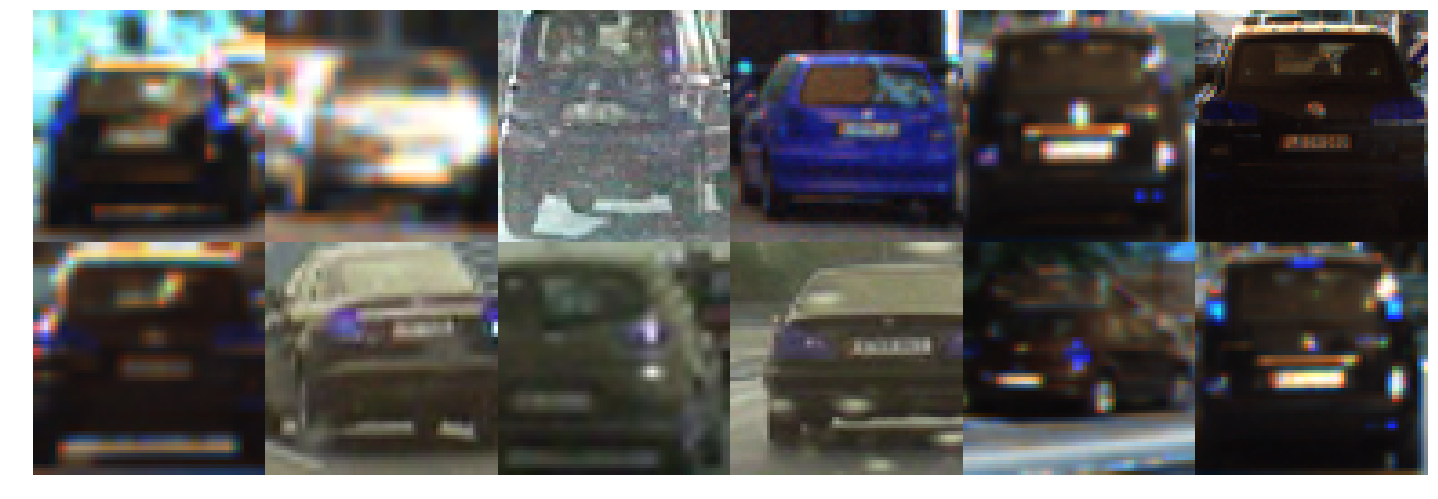

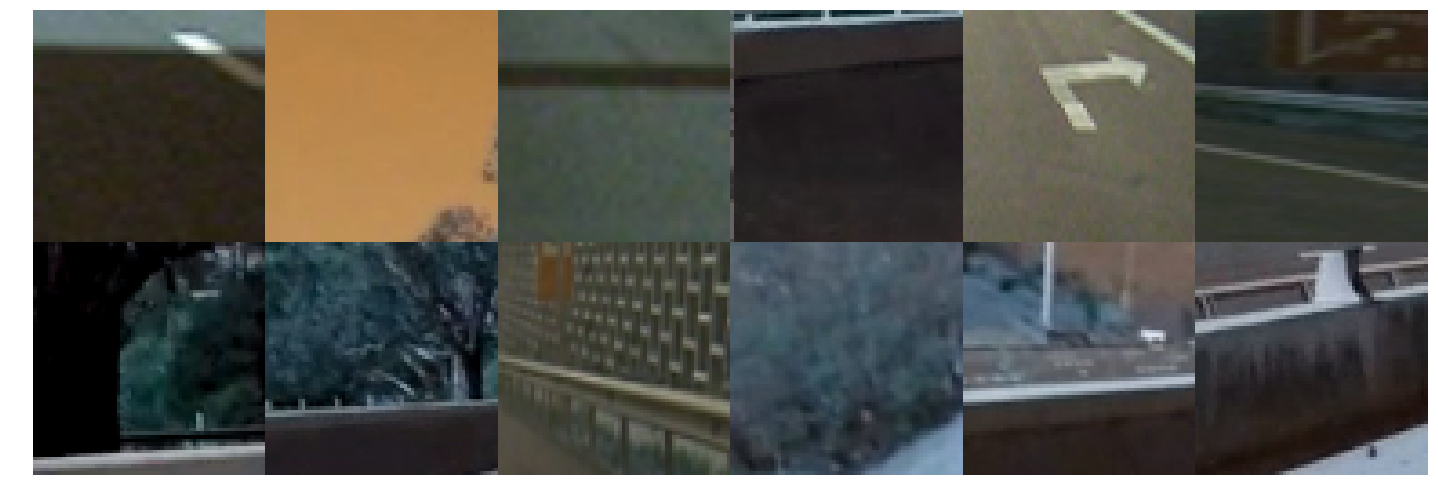

In [3]:
files_cars = glob.glob('./source_images/vehicles/**/*.png')
files_noncars = glob.glob('./source_images/non-vehicles/**/*.png')
print("Cars in dataset: {}; Non-cars in dataset: {}".format(len(files_cars), len(files_noncars)))

preview_cars = load_images(files_cars, num=12)
display_image_set(preview_cars, "cars")

preview_noncars = load_images(files_noncars, num=12)
display_image_set(preview_noncars, "noncars")

In [57]:
def to_colorspace(img_init, space='RGB'):
    img = np.copy(img_init)
    
    if space == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif space == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif space == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif space == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif space == 'gray':
        return np.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 2)
    else: 
        return img
    
def extract_hog(img, orient, ppc, cpb):
    feature, preview = hog(img, orientations=orient, pixels_per_cell=ppc, cells_per_block=cpb, 
                visualise=True, feature_vector=True)
    preview *= 255.0 / preview.max()
    preview = np.expand_dims(preview, 2)
    preview = np.array(cv2.merge((preview, preview, preview)), np.uint8)
    
    return feature, preview

def hog_features(img, orient, pix_per_cell, cell_per_block, channel=None):
    ppc = (pix_per_cell, pix_per_cell)
    cpb = (cell_per_block, cell_per_block)

    if channel is None:
        features = []
        previews = np.empty([0, img.shape[0], img.shape[1], img.shape[2]], dtype = np.uint8)
        
        for ch in range(img.shape[2]):
            feature, preview = extract_hog(img[:,:,ch], orient, ppc, cpb)
            features.append(feature)  
            previews = np.append(previews, preview[None,:], axis=0)

        features = np.ravel(features)
        return features, previews
    else:
        feature, preview = extract_hog(img[:,:,channel], orient, ppc, cpb)
        return feature, [preview]
    

def hog_images(imgs, channel=None, orient=9, pix_per_cell=8, cell_per_block=8, colorspace='YUV'):
    features = []
    previews = np.empty([0, imgs.shape[1], imgs.shape[2], imgs.shape[3]], dtype = np.uint8)

    for img in imgs:
        img_cc = to_colorspace(img, colorspace)
        
        if channel is None:
            previews = np.append(previews, img_cc[None,:], axis=0)
        else:
            preview = np.array(cv2.merge((img_cc[:,:,channel], img_cc[:,:,channel], img_cc[:,:,channel])), np.uint8)
            previews = np.append(previews, preview[None,:], axis=0)
            
        feature, preview = hog_features(img_cc, orient, pix_per_cell, cell_per_block, channel)
        features.append(feature)
        previews = np.append(previews, preview, axis=0)
        
    features = np.array(features).astype(np.float64)

    return features, previews

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


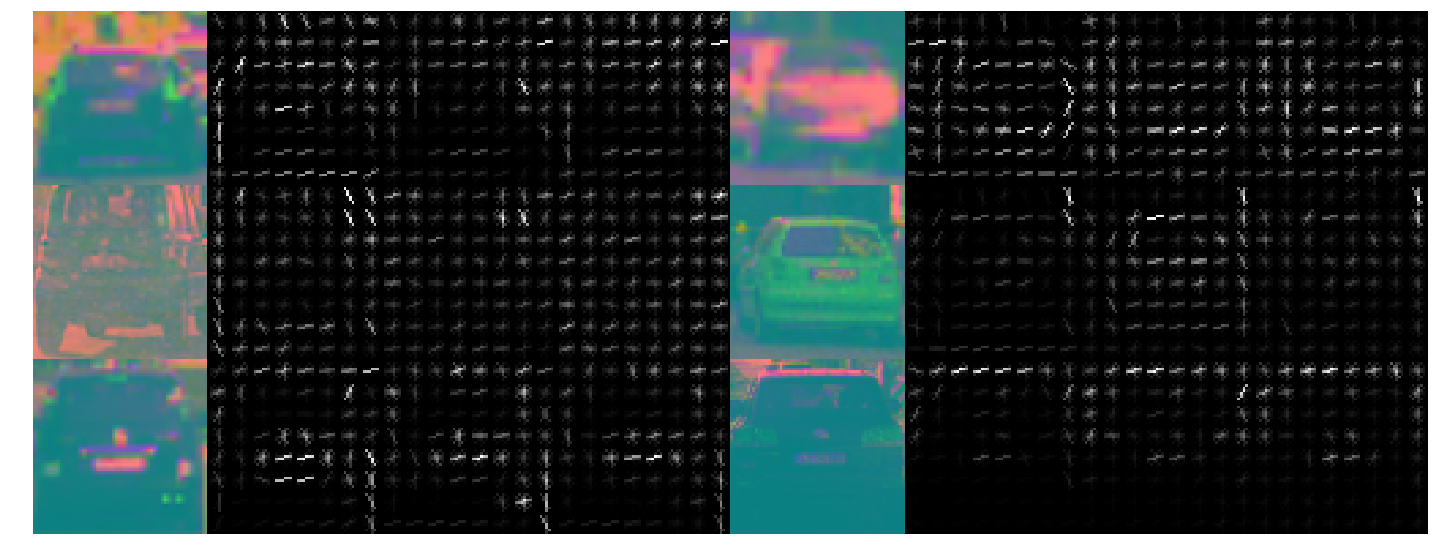

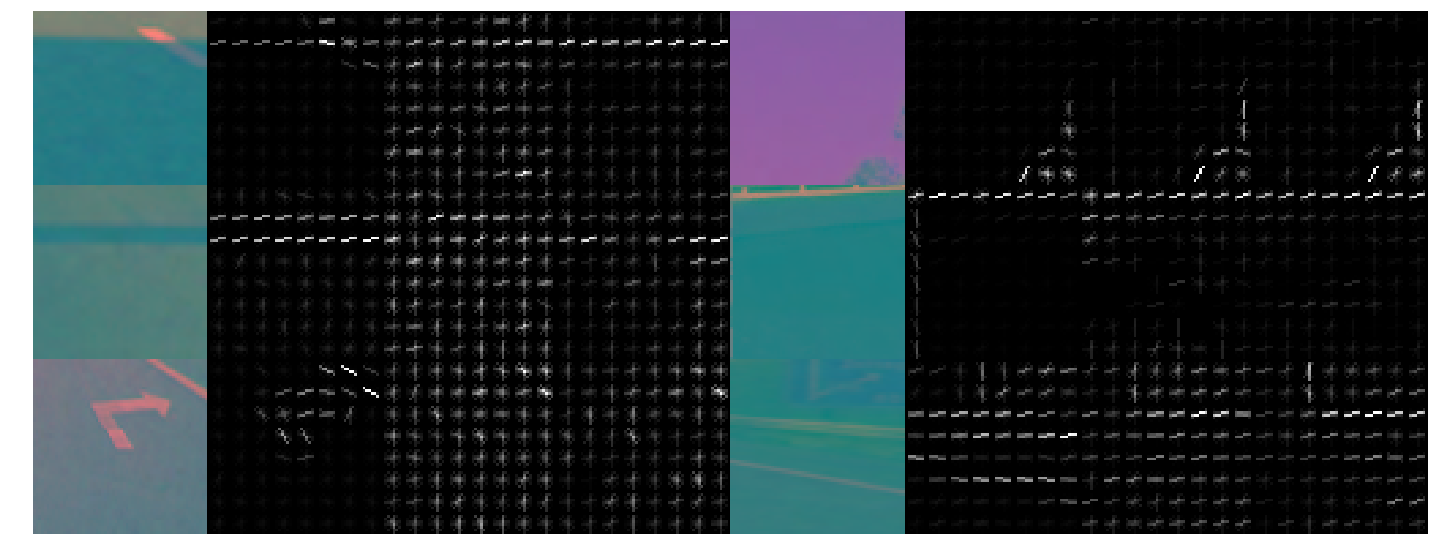

In [58]:
_, preview_hog_cars = hog_images(preview_cars[:6])
display_image_set(preview_hog_cars, "hog_cars", cols_num=8)

_, preview_hog_noncars = hog_images(preview_noncars[:6])
display_image_set(preview_hog_noncars, "hog_noncars", cols_num=8)

In [8]:
imgs = load_images(files_cars, num=100)

colorspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
orientations = range(6, 13)
px_per_cells = range(6, 17)
cells_per_blocks = range(1, 4)
channels = [None, 0, 1, 2]

for space in colorspaces:
    for orientation in orientations:
        for px_per_cell in px_per_cells:
            for cells_per_block in cells_per_blocks:
                for channel in channels:
                    t = time.time()
                    hog_images(imgs, channel=channel, orient=orientation, pix_per_cell=px_per_cell, 
                                                   cell_per_block=cells_per_block, colorspace=space)
                    t2 = time.time()
                    print('Images: {} | Time: {}sec | Space {} | Orient {} | PPC {} | CPB {} | Channel {}'
                          .format(len(imgs), round(t2 - t, 2), space, orientation, px_per_cell, cells_per_block, channel))

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Images: 100 | Time: 19.65sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel None
Images: 100 | Time: 6.96sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 0
Images: 100 | Time: 6.76sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 1
Images: 100 | Time: 6.65sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 2
Images: 100 | Time: 20.54sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel None
Images: 100 | Time: 6.4sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 0
Images: 100 | Time: 6.65sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 1
Images: 100 | Time: 6.35sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 2
Images: 100 | Time: 24.58sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel None
Images: 100 | Time: 8.66sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 0
Images: 100 | Time: 8.64sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 1
Images: 100 | Time: 11.19sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 2
Images: 100 | Time: 21.11sec | Space RGB

Images: 100 | Time: 2.06sec | Space RGB | Orient 6 | PPC 14 | CPB 2 | Channel 1
Images: 100 | Time: 1.84sec | Space RGB | Orient 6 | PPC 14 | CPB 2 | Channel 2
Images: 100 | Time: 5.61sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel None
Images: 100 | Time: 1.82sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 0
Images: 100 | Time: 1.85sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 1
Images: 100 | Time: 2.38sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 2
Images: 100 | Time: 6.22sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel None
Images: 100 | Time: 2.03sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 0
Images: 100 | Time: 2.39sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 1
Images: 100 | Time: 1.92sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 2
Images: 100 | Time: 6.42sec | Space RGB | Orient 6 | PPC 15 | CPB 2 | Channel None
Images: 100 | Time: 2.43sec | Space RGB | Orient 6 | PPC 15 | CPB 2 | Channel 0
Images: 100 | Time: 2.14sec | S

Images: 100 | Time: 5.74sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel None
Images: 100 | Time: 1.54sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 0
Images: 100 | Time: 1.44sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 1
Images: 100 | Time: 1.54sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 2
Images: 100 | Time: 4.34sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel None
Images: 100 | Time: 1.43sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 0
Images: 100 | Time: 1.51sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 1
Images: 100 | Time: 2.1sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 2
Images: 100 | Time: 4.1sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel None
Images: 100 | Time: 1.08sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 0
Images: 100 | Time: 0.89sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 1
Images: 100 | Time: 1.41sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 2
Images: 100 | Time: 2.79sec | Spa

KeyboardInterrupt: 

In [64]:
imgs_cars = load_images(files_cars)
imgs_noncars = load_images(files_noncars)

features_cars, _ = hog_images(imgs_cars, orient=11, pix_per_cell=16, cell_per_block=2, colorspace='YUV')
features_noncars, _ = hog_images(imgs_noncars, orient=11, pix_per_cell=16, cell_per_block=2, colorspace='YUV')

X = np.append(features_cars, features_noncars, axis=0)
y = np.append(np.ones(len(features_cars)), np.zeros(len(features_noncars)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Train features {}, labels {}".format(X_train.shape, y_train.shape))
print("Test features {}, labels {}".format(X_test.shape, y_test.shape))

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
svc = LinearSVC()

t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print('Training time', round(t2 - t, 2))
print('Test Accuracy', round(svc.score(X_test, y_test), 4))

batch = 10
print('Prediction:', svc.predict(X_test[0:batch]))
print('True Label:', y_test[0:batch])